# Final MVP - Datada Team - Vietnam Datathon Contest

## Time Series Analysis

### **Sales data area**

Sales data are collected every month from 2022-2023, the files follow the format

`TT T<month>-<year>.xlsx`

Where

`<month>` represents the month number (from 01 to 12)

`<year>` represents year number (2022 or 2023).

For example, the file “TT T01-2022.xlss” represents the sales data for January 2022

Each file includes the following data fields:

- `month`: month in year
- `week`: week in year
- `site`: warehouse/store ID
- `branch_id`: the branch ID
- `channel_id`: code of distribution channel
- `distribution_channel_code`: Determine the distribution channel’s unique code.
- `sold_quantity`: the number of products or units that have been sole (số lượng tiêu thụ)
- `cost_price`: the direct costs associated with producing or purchasing the goods that a company sells during a specific accounting period (Trị giá tiêu thụ -  giá vốn)
- `net_price`: the final price of a product (trị giá tiêu thị - giá sau chiết khấu)
- `customer_id`: the customer ID
- `product_id`: the product ID

### Import neccessary libraries

In [191]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings('ignore')

### Merge multiple files `TT T<month>-<year>.xlsx` into one

In [112]:
# Set the path to your dataset files
sales_files = glob.glob("Sales_mentor/TT T*.xlsx")

# Initialize an empty DataFrame to store the sales data
sales_data = pd.DataFrame()

# Read each sales file and concatenate them into a single DataFrame
for file in sales_files:
    df = pd.read_excel(file)
    sales_data = pd.concat([sales_data, df], ignore_index=True)


In [113]:
# Save the DataFrame to a CSV file
sales_data.to_csv('sales_data.csv', index=False)

In [114]:
sales_data

,month,week,site,branch_id,channel_id,distribution_channel,distribution_channel_code,sold_quantity,cost_price,net_price,customer_id,product_id
0,2022001,202203,1800,1800,Online,Online,ZF2,3,3465960,4816665,02757bde1,aa01577e94a049c395087645063c5275NAU42
1,2022001,202202,1105,1100,CHTT,Bán lẻ,FP,1,231200,340000,3dd717588,c5e8835a14e74ee2ba476536bedbd7e0DEN44
2,2022001,202204,1147,1100,CHTT,Bán lẻ,FP,1,238000,350000,255bcbc83,d62c72df8f454e3b8cb3fe9fc0c508abDEN43
3,2022001,202202,1502,1500,CHTT,Bán lẻ,FP,1,244800,360000,948340f03,4615b124d7a743d6b536515c2fb486b5DEN37
4,2022001,202204,1115,1100,CHTT,Bán lẻ,FP,1,125800,185000,0ad09228f,4cabab90b40841b4b100cdc0969742aaDOO39
...,...,...,...,...,...,...,...,...,...,...,...,...
2495918,2022012,202252,1100,1100,TGPP,Phát sinh,ZF3,1,69434,79645,a3f1429b7,16fed9174bd84166893eab741c641316HOD38
2495919,2022012,202249,1513,1500,CHTT,Bán lẻ,FP,1,212308,250000,3ec77a1f4,26716e2d85294a31b32807473ce76d0fXNH36
2495920,2022012,202252,1101,1100,CHTT,Bán lẻ,FP,1,379885,559000,dd5a95cfa,34e8a3fbf13245749251726178b2756cHOG39
2495921,2022012,202250,1100,1100,TGPP,Hợp đồng,ZF1,3,650946,746673,ecaa638ff,0b45b1a1fd5a4b009d4a20fb355b2486XDG36


In [115]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495923 entries, 0 to 2495922
Data columns (total 12 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   month                      int64 
 1   week                       int64 
 2   site                       int64 
 3   branch_id                  int64 
 4   channel_id                 object
 5   distribution_channel       object
 6   distribution_channel_code  object
 7   sold_quantity              int64 
 8   cost_price                 int64 
 9   net_price                  int64 
 10  customer_id                object
 11  product_id                 object
dtypes: int64(7), object(5)
memory usage: 228.5+ MB


In [116]:
missing_values = sales_data.isnull().sum()
missing_values

month                        0
week                         0
site                         0
branch_id                    0
channel_id                   0
distribution_channel         0
distribution_channel_code    0
sold_quantity                0
cost_price                   0
net_price                    0
customer_id                  0
product_id                   0
dtype: int64

In [117]:
sales_data['total_sales'] = sales_data['sold_quantity'] * sales_data['net_price']

# Calculate total sales for each branch/warehouse
total_sales_per_channel = sales_data.groupby(['channel_id', 'month', 'week'])['total_sales'].sum().reset_index()

# Calculate total sales for each product
total_sales_per_distribution_channel = sales_data.groupby(['distribution_channel', 'month', 'week'])['total_sales'].sum().reset_index()

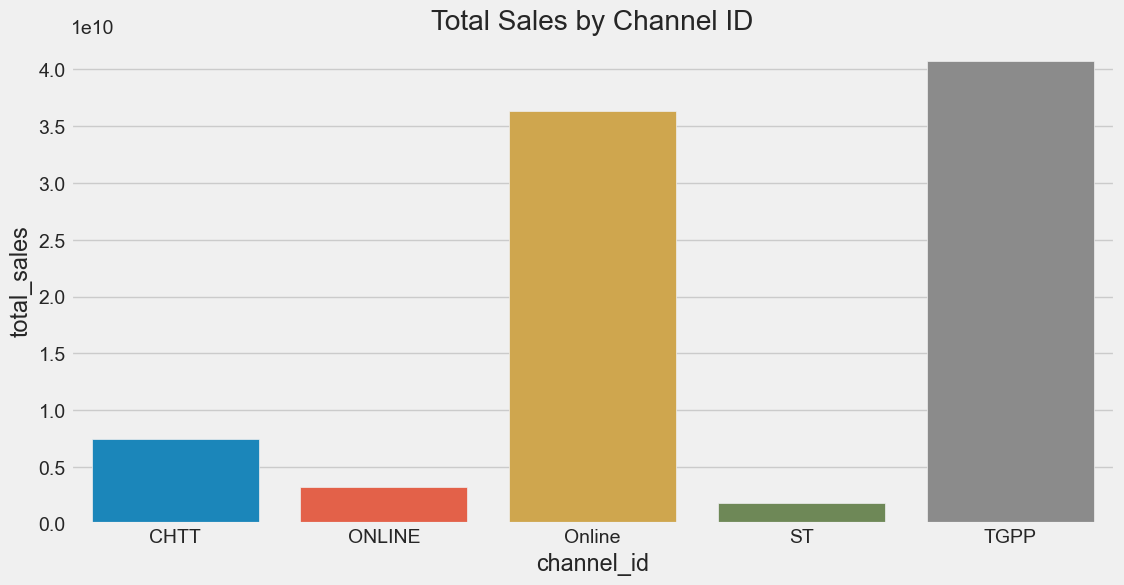

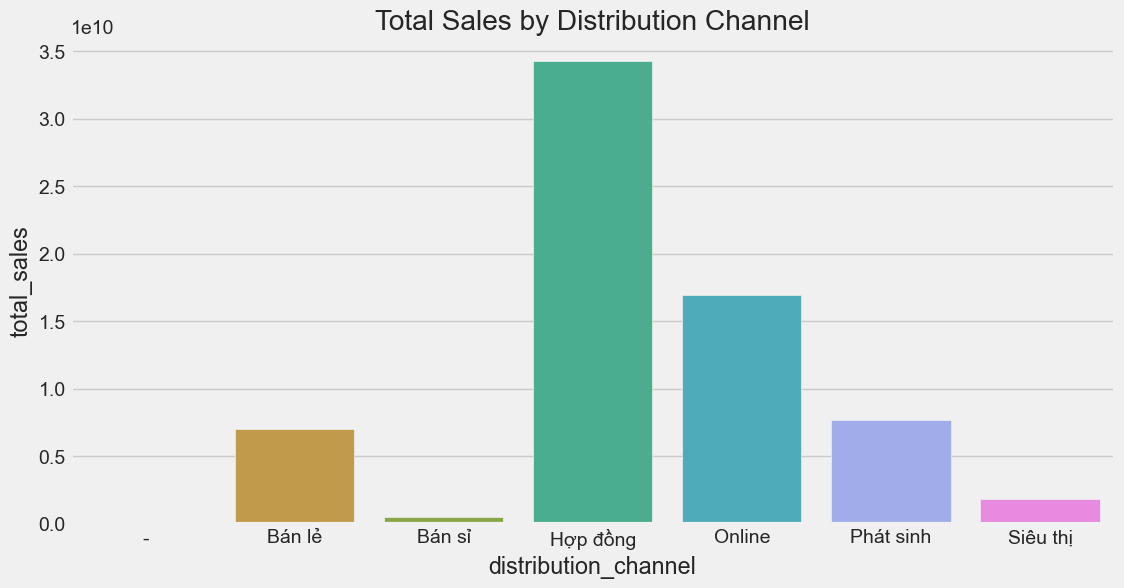

In [174]:
# Visualize the results
plt.figure(figsize=(12, 6))
sns.barplot(x='channel_id', y='total_sales', data=total_sales_per_channel, ci=None)
plt.title('Total Sales by Channel ID')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='distribution_channel', y='total_sales', data=total_sales_per_distribution_channel, ci=None)
plt.title('Total Sales by Distribution Channel')
plt.show()

### **Preprocessing**

In [168]:
# Assuming 'df' is your DataFrame
sales_data['year'] = sales_data['month'].astype(str).str[:4].astype(int)
sales_data['month'] = sales_data['month'].astype(str).str[-2:].astype(int)
sales_data['week'] = sales_data['week'].astype(str).str[-2:].astype(int)  # Extract the last two digits to get the week

# Now 'year', 'month', and 'week' are extracted as separate columns

# Display the modified DataFrame
sales_data[['year', 'month', 'week']]

,year,month,week
0,1,1,3
1,1,1,2
2,1,1,4
3,1,1,2
4,1,1,4
...,...,...,...
2495918,12,12,52
2495919,12,12,49
2495920,12,12,52
2495921,12,12,50


Let's convert `year` and `week of year` to `date`

In [146]:
dates = sales_data.year*100+sales_data.week
sales_data['date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
sales_data['date']

0         2022-01-23
1         2022-01-16
2         2022-01-30
3         2022-01-16
4         2022-01-30
             ...    
2495918   2023-01-01
2495919   2022-12-11
2495920   2023-01-01
2495921   2022-12-18
2495922   2022-12-25
Name: date, Length: 2495923, dtype: datetime64[ns]

In [121]:
# Calculate total cost for each transaction
sales_data['total_cost'] = sales_data['sold_quantity'] * sales_data['cost_price']

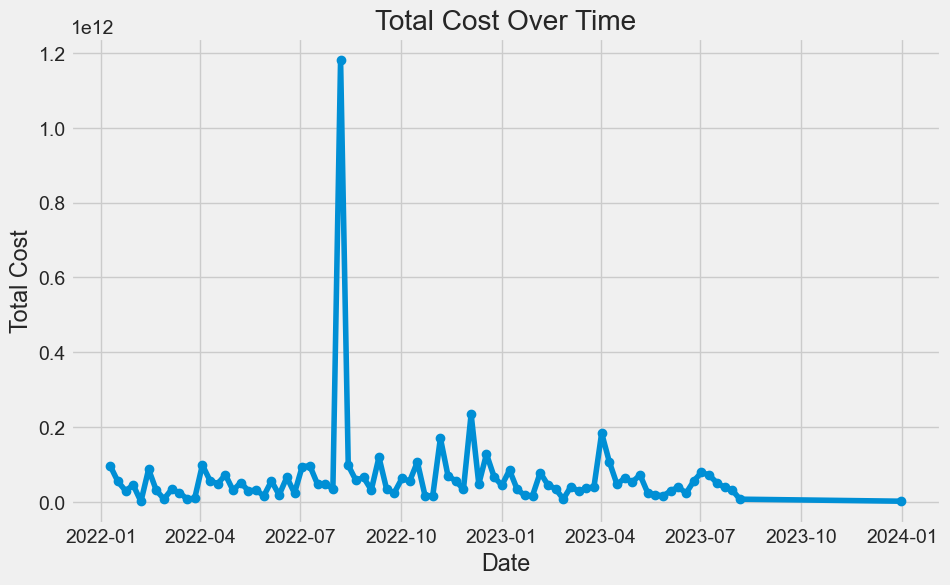

In [175]:
# Aggregate total cost over time

total_cost_over_time = sales_data.groupby(['date'])['total_cost'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(total_cost_over_time['date'], total_cost_over_time['total_cost'], marker='o')
plt.title('Total Cost Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cost')
plt.grid(True)
plt.show()

In [148]:
# Calculate profit for each transaction
sales_data['profit'] = sales_data['total_sales'] - sales_data['total_cost']

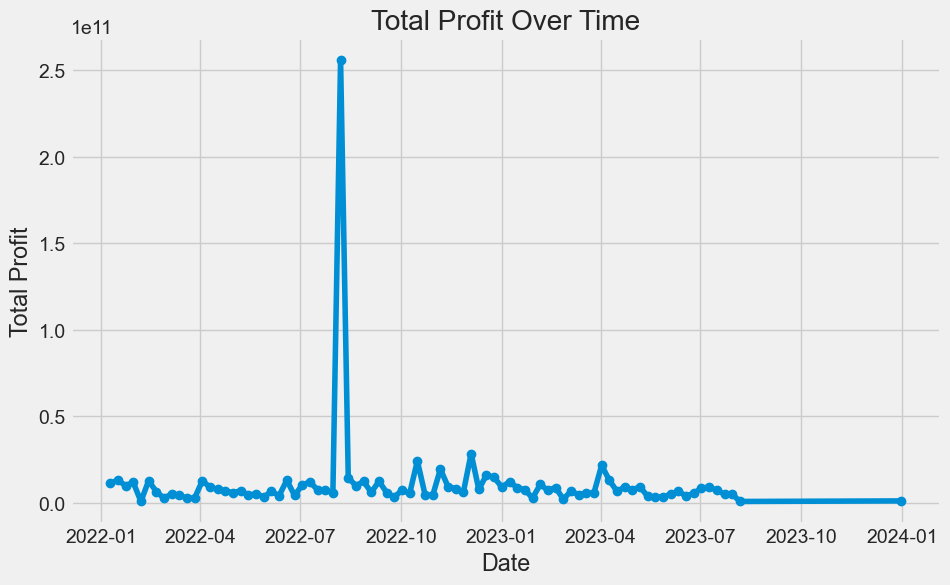

In [176]:
total_profit_over_time = sales_data.groupby(['date'])['profit'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(total_profit_over_time['date'], total_profit_over_time['profit'], marker='o')
plt.title('Total Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Total Profit')
plt.grid(True)
plt.show()

### **Data Modeling**

#### **ARIMA Model**

Test Mean Squared Error: 0.0008972326763834324


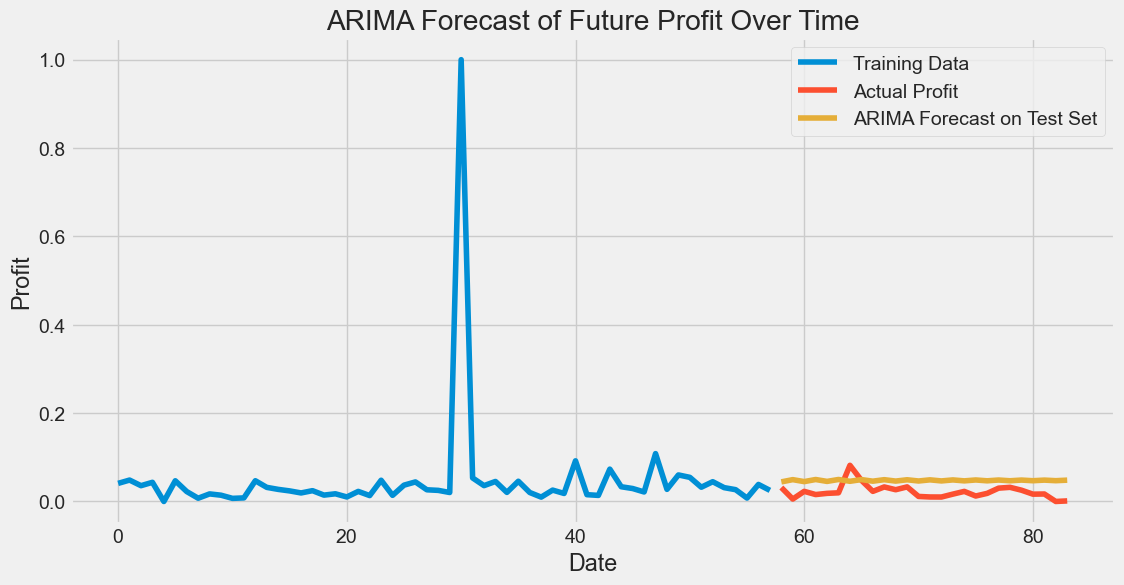

In [324]:
scaler = MinMaxScaler()

total_profit_over_time['profit'] = scaler.fit_transform(total_profit_over_time[['profit']])

# Split the data into training and testing sets
train_size = int(len(total_profit_over_time) * 0.7)
train, test = total_profit_over_time[:train_size], total_profit_over_time[train_size:]

# Build and fit the ARIMA model on the training set
model = ARIMA(train['profit'], order=(5, 1, 2))  # Adjust order as needed
fit_model = model.fit()

# Forecast future values on the test set
forecast_values_test = fit_model.forecast(steps=len(test))

# Evaluate the model on the test set
mse_test = mean_squared_error(test['profit'], forecast_values_test)
print(f'Test Mean Squared Error: {mse_test}')

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['profit'], label='Training Data')
plt.plot(test.index, test['profit'], label='Actual Profit')
plt.plot(test.index, forecast_values_test, label='ARIMA Forecast on Test Set')
plt.title('ARIMA Forecast of Future Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()

#### **SARIMAX Model**

Test Mean Squared Error: 0.003914650234519457


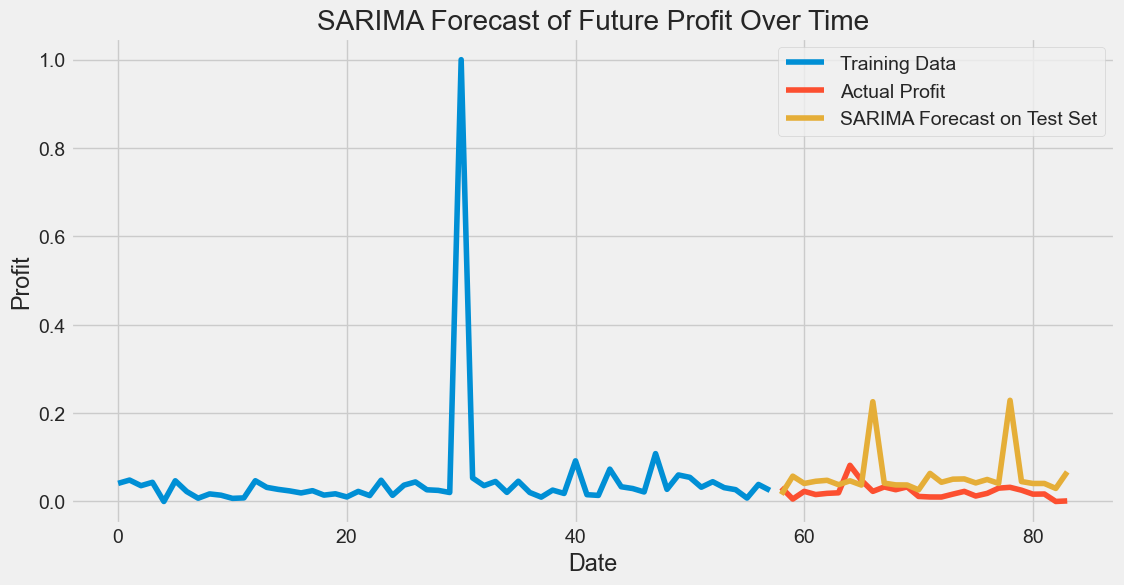

In [325]:
model = SARIMAX(train['profit'], order=(5, 1, 2), seasonal_order=(0, 1, 1, 12))
fit_model = model.fit()

# Forecast future values on the test set
forecast_values_test = fit_model.forecast(steps=len(test))

# Evaluate the model on the test set
mse_test = mean_squared_error(test['profit'], forecast_values_test)
print(f'Test Mean Squared Error: {mse_test}')

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['profit'], label='Training Data')
plt.plot(test.index, test['profit'], label='Actual Profit')
plt.plot(test.index, forecast_values_test, label='SARIMA Forecast on Test Set')
plt.title('SARIMA Forecast of Future Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()

#### **LSTM Model**

1/1 [==============================] - 0s 147ms/step
Test Mean Squared Error: 4.174277621660407e-05


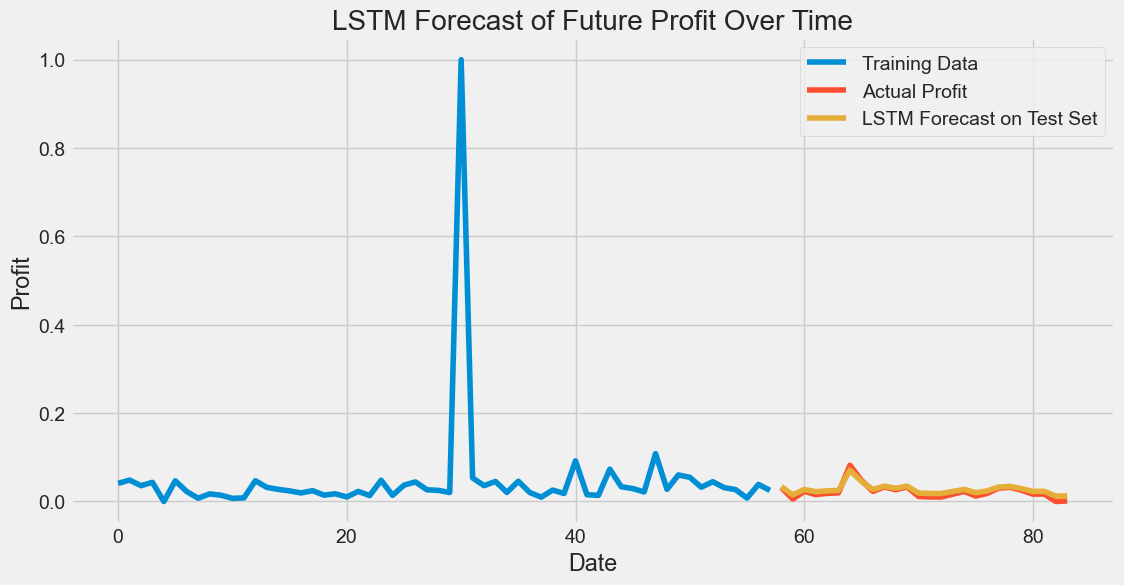

In [326]:
# Split the data into training and testing sets
train_size = int(len(total_profit_over_time) * 0.7)
train, test = total_profit_over_time[:train_size], total_profit_over_time[train_size:]

# Reshape the data to be 3D, as expected by the LSTM layer
train_values = np.array(train['profit']).reshape(-1, 1, 1)
test_values = np.array(test['profit']).reshape(-1, 1, 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model on the training set
model.fit(train_values, train['profit'], epochs=200, verbose=0)

# Forecast future values on the test set
forecast_values_test = model.predict(test_values)

# Evaluate the model on the test set
mse_test = mean_squared_error(test['profit'], forecast_values_test)
print(f'Test Mean Squared Error: {mse_test}')

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['profit'], label='Training Data')
plt.plot(test.index, test['profit'], label='Actual Profit')
plt.plot(test.index, forecast_values_test, label='LSTM Forecast on Test Set')
plt.title('LSTM Forecast of Future Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()